**Import necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Load the dataset**

In [2]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split = ["train[:70%]", "train[70%:80%]", "train[80%:]"],
    as_supervised=True
)


In [3]:
print("Number of training samples:", train_ds.cardinality().numpy())
print("Number of Validation samples:", validation_ds.cardinality().numpy())
print("Number of test samples:", test_ds.cardinality().numpy())

Number of training samples: 16283
Number of Validation samples: 2327
Number of test samples: 4652


In [4]:
# Limit the number of samples in each dataset
num_train_samples = 3000  # Specify the number of training samples you want
num_val_samples = 400      # Specify the number of validation samples
num_test_samples = 400     # Specify the number of test samples

train_ds = train_ds.take(num_train_samples)
validation_ds = validation_ds.take(num_val_samples)
test_ds = test_ds.take(num_test_samples)

**Display the images**

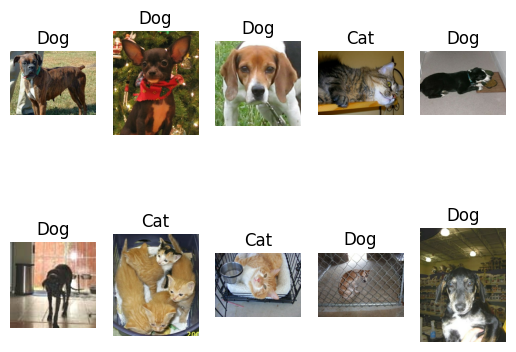

In [5]:
for i, (image, label) in enumerate(train_ds.take(10)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(image)
        plt.title("Cat" if label == 0 else "Dog")
        plt.axis("off")
plt.show()

**Normalizing/Standardizing the images**

In [6]:
IMG_SIZE = 150  # Resize the images to 150*150 (the input size for Xception)

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image, label

train_ds = train_ds.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

**i) Transfer Learning (Without Fine-tuning)**

**Load the Pre-trained Xception Model**

In [12]:
from tensorflow.keras.applications import Xception

# Load the pre-trained Xception model
base_model = Xception(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

In [13]:
# Freeze the base model
base_model.trainable = False

**Add custom layers on top**

In [14]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8883 - loss: 0.2799 - val_accuracy: 0.9625 - val_loss: 0.0967
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.9607 - loss: 0.0961 - val_accuracy: 0.9600 - val_loss: 0.0828
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.9718 - loss: 0.0768 - val_accuracy: 0.9675 - val_loss: 0.0803
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9757 - loss: 0.0672 - val_accuracy: 0.9650 - val_loss: 0.0750
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.9794 - loss: 0.0602 - val_accuracy: 0.9625 - val_loss: 0.0743
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.9809 - loss: 0.0552 - val_accuracy: 0.9675 - val_loss: 0.0728
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9830 - loss: 0.0493 - val_accuracy: 0.9675 - val_loss: 0.0723
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9700 - v

**Plot the performance of the model**

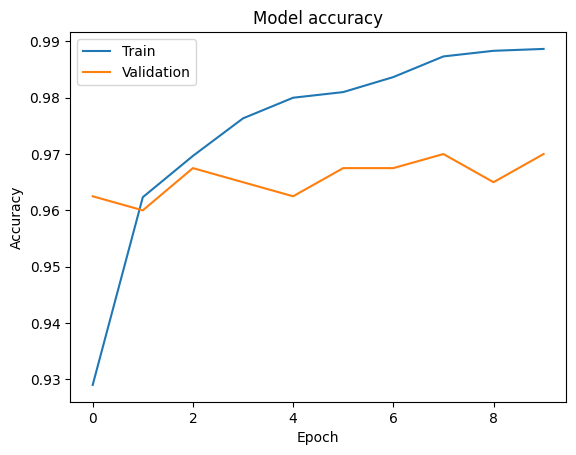

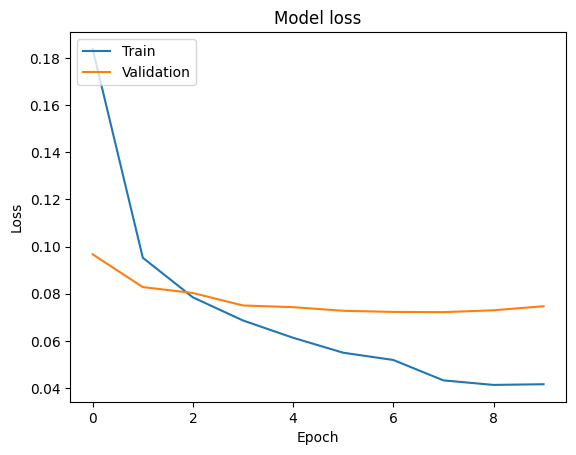

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [18]:
# Evaluate the model on the test data
model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9777 - loss: 0.0584


[0.06293061375617981, 0.9700000286102295]

**Transfer Learning (With Fine-Tuning)**

In [53]:
# Unfreeze the top layers of the base model
base_model.trainable = True

In [54]:
# Fine-tune only the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,481,533 (238.35 MB)

 Trainable params: 3,165,697 (12.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 41,618,004 (158.76 MB)

In [55]:
# Compile the model again with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [56]:
# Fine-tune the model
history_fine = model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 408s 4s/step - accuracy: 0.9676 - loss: 0.1056 - val_accuracy: 0.9750 - val_loss: 0.0827
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9825 - loss: 0.0811 - val_accuracy: 0.9750 - val_loss: 0.0848
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9865 - loss: 0.0720 - val_accuracy: 0.9750 - val_loss: 0.0837
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9870 - loss: 0.0628 - val_accuracy: 0.9750 - val_loss: 0.0817
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9874 - loss: 0.0583 - val_accuracy: 0.9750 - val_loss: 0.0795
